In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from glob import glob
import pathlib
import common

FONT_SIZE = 15
plt.rc('font', size=FONT_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=FONT_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=FONT_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=FONT_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=FONT_SIZE)    # legend fontsize
plt.rc('figure', titlesize=FONT_SIZE)  # fontsize of the figure title
matplotlib.rc('lines', linewidth=3)

In [239]:
fig_dir = '/data/zhenyus/webcachesim/notebook/figures/'

In [262]:
color_map = {
    'wc400m.tr': 'r',
    'traceHK.tr': 'b',
    'traceUS.tr': 'g',
}

In [245]:
attributes_default = {
    'wc400m.tr': {
        'batch_size': '100000',
        'sample_rate': '64',
        'forget_window': '80000000',
        'num_iterations': '32',
        'learning_rate': '0.1',
    },
    'traceHK.tr': {
        'batch_size': '100000',
        'sample_rate': '64',
        'forget_window': '10000000',
        'num_iterations': '32',
        'learning_rate': '0.1',
    },
    'traceUS.tr': {
        'batch_size': '100000',
        'sample_rate': '64',
        'forget_window': '40000000',
        'num_iterations': '32',
        'learning_rate': '0.1',
    }
}

In [246]:
trace_map = {
    'wc400m.tr': 'Wiki',
    'traceHK.tr': 'CDN-A',
    'traceUS.tr': 'CDN-E',
}

In [247]:
def get_attribute_label(idx):
    if idx == 'forget_window':
        return 'memory window'
    elif idx == 'num_iterations':
        return '#trees'
    return idx

In [275]:
# globally refresh
df = common.load_reports()

In [249]:
def get_index_fix_attribute(df, attribute, value):
    return df[attribute] == value

In [276]:
FONT_SIZE = 34
plt.rc('font', size=FONT_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=FONT_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=FONT_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=FONT_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=FONT_SIZE)    # legend fontsize
plt.rc('figure', titlesize=FONT_SIZE)  # fontsize of the figure title
matplotlib.rc('lines', linewidth=3)

In [277]:
filter_idx = ((
    (df.trace_file == 'wc400m.tr') 
    & (df.cache_size == 128*2**30)
    & (df.n_warmup == 80000000)
    & (df.cache_type =='GDBT')
    & (df.version == 'sensitivity')
) | (
    (df.trace_file == 'traceHK.tr') 
    & (df.cache_size == 128*2**30)
    & (df.n_warmup == 80000000)
    & (df.cache_type =='GDBT')
    & (df.version == 'sensitivity')
) | (
    (df.trace_file == 'traceUS.tr') 
    & (df.cache_size == 128*2**30)
    & (df.n_warmup == 100000000)
    & (df.cache_type =='GDBT')
    & (df.version == 'sensitivity')
)


)
df1 = df[filter_idx].copy()

In [273]:
df1.learning_rate.drop_duplicates()

17245     0.1
17253     0.2
17254       1
17255    0.05
17257     0.5
17259    0.01
17260    0.02
Name: learning_rate, dtype: object

In [274]:
attribute_changes = ['batch_size', 'sample_rate', 'num_iterations', 'learning_rate']
for attribute_change in attribute_changes:
    for trace in attributes_default:
        index = df1['trace_file'] == trace
        for a in attributes_default[trace]:
            if a != attribute_change:
                index = index & get_index_fix_attribute(df1, a, attributes_default[trace][a])
        df2 = df1[index].copy()
        df2[attribute_change] = df2[attribute_change].astype(float)
        if attribute_change == 'learning_rate':
            df2 = df2[df2[attribute_change]<=0.5]
        df2 = df2.sort_values(attribute_change)
        print(f'{attribute_change} {trace_map[trace]} {(df2.byte_hit_rate.max() - df2.byte_hit_rate.min())}')

batch_size Wiki 0.002526999999999946
batch_size CDN-A 0.0007019999999999804
batch_size CDN-E 0.0010069999999999801
sample_rate Wiki 0.015932000000000057
sample_rate CDN-A 0.004602999999999913
sample_rate CDN-E 0.0037729999999999153
num_iterations Wiki 0.005258000000000096
num_iterations CDN-A 0.005746999999999947
num_iterations CDN-E 0.005117000000000038
learning_rate Wiki 0.00848099999999996
learning_rate CDN-A 0.0068669999999999565
learning_rate CDN-E 0.005138000000000087


Wikipedia 0.2526999999999946
CDN Asia 0.07019999999999804
CDN East Cost 0.10069999999999801


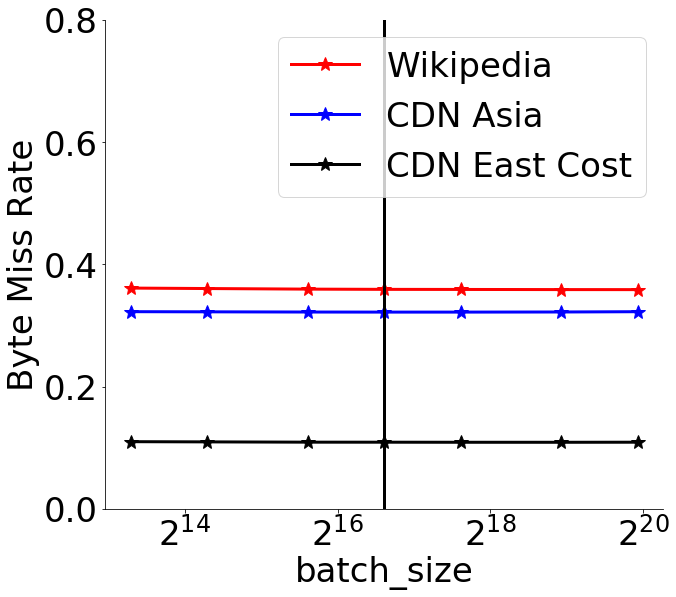

In [208]:
attribute_change = 'batch_size'
fig, ax = plt.subplots(figsize=(10, 9))

for trace in attributes_default:
    index = df1['trace_file'] == trace
    for a in attributes_default[trace]:
        if a != attribute_change:
            index = index & get_index_fix_attribute(df1, a, attributes_default[trace][a])
    df2 = df1[index].copy()
    df2[attribute_change] = df2[attribute_change].astype(float)
    
    df2 = df2.sort_values(attribute_change)
    print(f'{trace_map[trace]} {100*(df2.byte_hit_rate.max() - df2.byte_hit_rate.min())}')
    ax.axvline(int(attributes_default[trace][attribute_change]), color=color_map[trace])
    ax.semilogx(df2[attribute_change],
            1-df2.byte_hit_rate,
                marker='*',
               basex=2,
                label=trace_map[trace],
                color=color_map[trace],
               markersize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel(f'{get_attribute_label(attribute_change)}')
plt.ylabel('Byte Miss Rate')
plt.legend()
# plt.title(f'{trace} 128GB')
plt.ylim(0, 0.8)
plt.show()

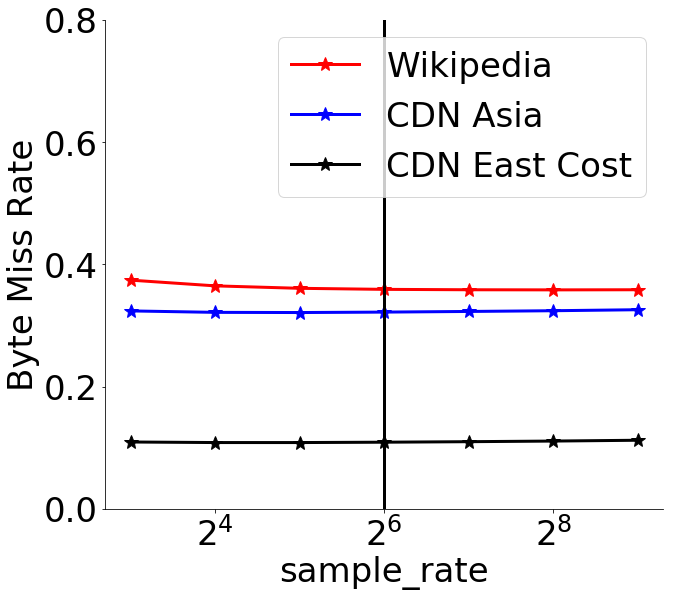

In [195]:
attribute_change = 'sample_rate'
fig, ax = plt.subplots(figsize=(10, 9))

for trace in attributes_default:
    index = df1['trace_file'] == trace
    for a in attributes_default[trace]:
        if a != attribute_change:
            index = index & get_index_fix_attribute(df1, a, attributes_default[trace][a])
    df2 = df1[index].copy()
    df2[attribute_change] = df2[attribute_change].astype(float)
    
    df2 = df2.sort_values(attribute_change)
    ax.axvline(int(attributes_default[trace][attribute_change]), color=color_map[trace])
    ax.semilogx(df2[attribute_change],
            1-df2.byte_hit_rate,
                marker='*',
               basex=2,
                label=trace_map[trace],
                color=color_map[trace],
               markersize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel(f'{get_attribute_label(attribute_change)}')
plt.ylabel('Byte Miss Rate')
plt.legend()
# plt.title(f'{trace} 128GB')
plt.ylim(0, 0.8)
plt.show()

In [278]:
valid_sizes = {
    'wc400m.tr': {'10000000', '20000000', '50000000', '80000000', '100000000', '200000000', '400000000'},
    'traceHK.tr': {'1000000', '2000000', '5000000', '10000000', '20000000', '50000000', '100000000'},
    'traceUS.tr': {'5000000', '10000000', '20000000', '40000000', '50000000', '100000000', '200000000'},
}

In [279]:
FONT_SIZE = 30
plt.rc('font', size=FONT_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=FONT_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=FONT_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=FONT_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=FONT_SIZE)    # legend fontsize
plt.rc('figure', titlesize=FONT_SIZE)  # fontsize of the figure title
matplotlib.rc('lines', linewidth=3)

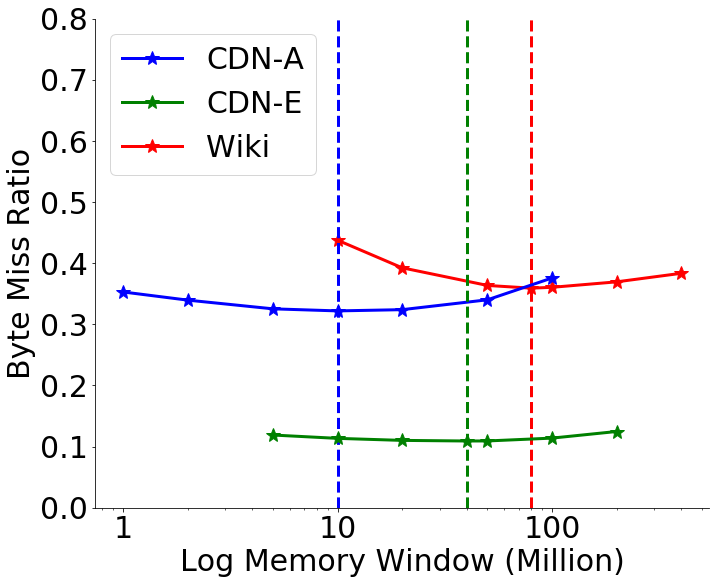

In [280]:
attribute_change = 'forget_window'
fig, ax = plt.subplots(figsize=(11, 9))

for trace in attributes_default:
    index = df1['trace_file'] == trace
    for a in attributes_default[trace]:
        if a != attribute_change:
            index = index & get_index_fix_attribute(df1, a, attributes_default[trace][a])
    index = index & (df1.forget_window.isin(valid_sizes[trace]))
    df2 = df1[index].copy()
    df2[attribute_change] = df2[attribute_change].astype(float)
#     print(df2[['trace_file', 'forget_window', 'byte_hit_rate']])
    
    df2 = df2.sort_values(attribute_change)
    ax.axvline(int(attributes_default[trace][attribute_change])/1e6, 
               color=color_map[trace],
              linestyle='--')
    ax.semilogx(df2[attribute_change]/1e6,
            1-df2.byte_hit_rate,
                marker='*',
               basex=10,
                label=trace_map[trace],
                color=color_map[trace],
               markersize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xticks((1, 10, 100))
ax.set_xticklabels(('1', '10', '100')) 

plt.xlabel(f'Log Memory Window (Million)')
plt.ylabel('Byte Miss Ratio')
plt.ylim(0)
handles, labels = ax.get_legend_handles_labels()
permutations = [1, 2, 0]
manual_handles = [handles[i] for i in permutations]
manual_labels = [labels[i] for i in permutations]
plt.legend(manual_handles, 
           manual_labels,
          )
plt.savefig(f"{fig_dir}/evaluation_sensitivity_window.pdf",
        bbox_inches = 'tight', 
        pad_inches = 0)
# plt.title(f'{trace} 128GB')
plt.ylim(0, 0.8)
plt.show()

In [236]:
labels

['Wiki', 'CDN-A', 'CDN-E']

IndexError: list index out of range

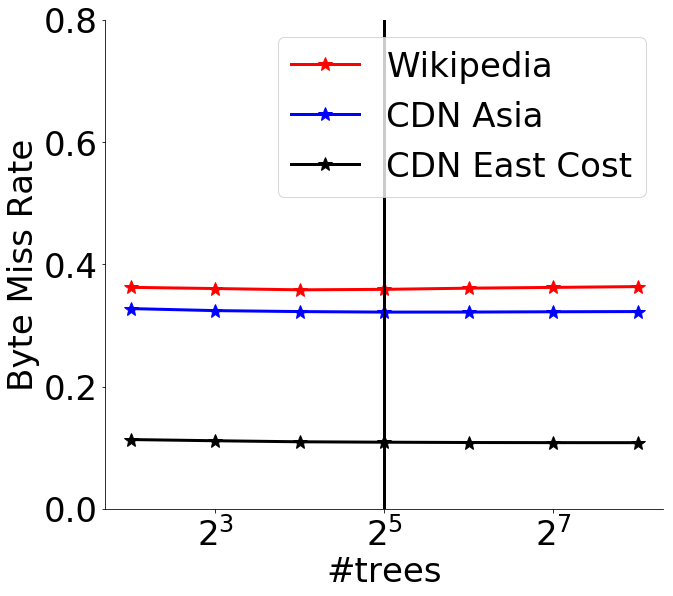

In [197]:
attribute_change = 'num_iterations'
fig, ax = plt.subplots(figsize=(10, 9))

for trace in attributes_default:
    index = df1['trace_file'] == trace
    for a in attributes_default[trace]:
        if a != attribute_change:
            index = index & get_index_fix_attribute(df1, a, attributes_default[trace][a])
    df2 = df1[index].copy()
    df2[attribute_change] = df2[attribute_change].astype(float)
    
    df2 = df2.sort_values(attribute_change)
    ax.axvline(int(attributes_default[trace][attribute_change]), color=color_map[trace])
    ax.semilogx(df2[attribute_change],
            1-df2.byte_hit_rate,
                marker='*',
               basex=2,
                label=trace_map[trace],
                color=color_map[trace],
               markersize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel(f'{get_attribute_label(attribute_change)}')
plt.ylabel('Byte Miss Rate')
plt.legend()
# plt.title(f'{trace} 128GB')
plt.ylim(0, 0.8)
plt.show()

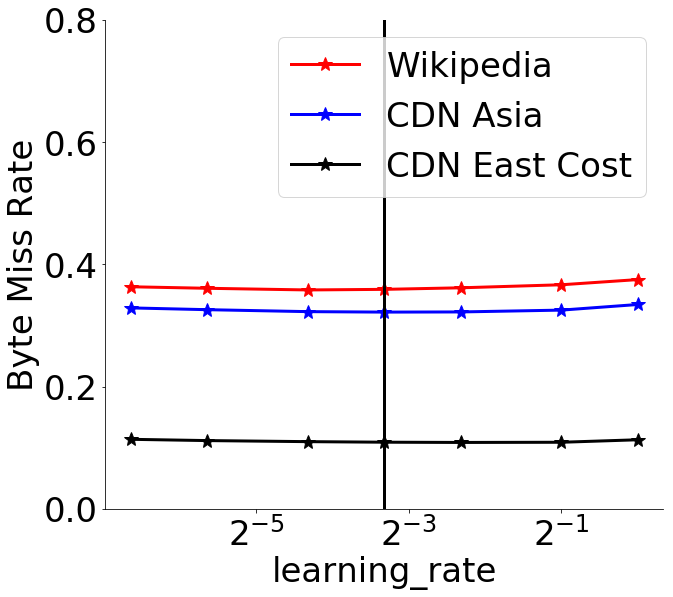

In [198]:
attribute_change = 'learning_rate'
fig, ax = plt.subplots(figsize=(10, 9))

for trace in attributes_default:
    index = df1['trace_file'] == trace
    for a in attributes_default[trace]:
        if a != attribute_change:
            index = index & get_index_fix_attribute(df1, a, attributes_default[trace][a])
    df2 = df1[index].copy()
    df2[attribute_change] = df2[attribute_change].astype(float)
    
    df2 = df2.sort_values(attribute_change)
    ax.axvline(float(attributes_default[trace][attribute_change]), color=color_map[trace])
    ax.semilogx(df2[attribute_change],
            1-df2.byte_hit_rate,
                marker='*',
               basex=2,
                label=trace_map[trace],
                color=color_map[trace],
               markersize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel(f'{get_attribute_label(attribute_change)}')
plt.ylabel('Byte Miss Rate')
plt.legend()
# plt.title(f'{trace} 128GB')
plt.ylim(0, 0.8)
plt.show()